In [1]:
### 前回からの修正点
# ・新しい解析フォルダに切り替えた時に必要なフォルダ作成（動作確認済）
# ・データシート2種類作成(datasheet_all, datasheet_202212〇〇_tanaka_pattern〇)(ALL or per INFO)（動作確認済）
# ・csvモジュールをデータシートへの読み書き部分はpandasに変更
# ・プログラムモード設定
# ・オプティカルフロー部分はショートカットしない（ゴニオもエコーもPreprocessの時のみショートカットあり）
# ・解析パラメータを5つ設定（fp_detection_pattern以外完了）

In [2]:
##### 使用するライブラリ・モジュールのインポート

import os
import csv
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy import signal
import cv2
from sklearn.metrics import r2_score
import pandas as pd
import math
import datetime

# 実行時間取得
updated_date = datetime.datetime.now().strftime('%Y/%m/%d %H:%M')
print("updated_date: " + updated_date)
print(type(updated_date))

updated_date: 2022/12/05 19:51
<class 'str'>


In [3]:
##### データ解析アルゴリズムパターン


### 特徴点選出パターン
# 1: 特徴点のx,y座標それぞれの相関係数を出し，その大きい方を全特徴点で比較し，大きい順にfeature_points個取り出す．
#    解析には各特徴点の相関係数の大きかった方の座標データのみを使用する．
# 2: 特徴点のx,y座標それぞれの相関係数を出し，その平均を全特徴点で比較し，大きい順にfeature_points個取り出す．
#    解析には各特徴点の両方の座標データを使用する．
# 3: 相関〇〇以上の特徴点のみ使用する
fp_selection_pattern = 1


### 特徴点検出パターン
# 1: コーナー検出
# 2: グリッドでプロット
fp_detection_pattern = 1


### フレーム範囲パターン
# 1: trim_w = 0, trim_h = 0（全範囲使用）
# 2: trim_w = 80, trim_h = 60
# 3: trim_w = 80, trim_h = 150
frame_range_pattern = 3


### 特徴点データへのローパスフィルターパターン
# 1: かけない
# 2: ローパスフィルタをかける
lowpass_filter_pattern = 1


### 正則化パターン
# 1: 入れない
# 2: 正則化を入れる
regularization_pattern = 2


print("fp_selection_pattern: " + str(fp_selection_pattern))
print("fp_detection_pattern: " + str(fp_detection_pattern))
print("frame_range_pattern: " + str(frame_range_pattern))
print("lowpass_filter_pattern: " + str(lowpass_filter_pattern))
print("regularization_pattern: " + str(regularization_pattern))

fp_selection_pattern: 1
fp_detection_pattern: 1
frame_range_pattern: 3
lowpass_filter_pattern: 1
regularization_pattern: 2


In [4]:
##### プログラムのモード選択
#### 1: 通常モード：　data_Noを指定して解析
#### 2: 書き込みモード：　データシートへの書き込みのみ（DATA_INFOを指定する）

program_mode = 1
print("プログラムモード：" + str(program_mode))


# 通常モード(program_mode = 1)の時，解析用パラメータを設定する
if program_mode == 1:
    
    ## データ番号（ターゲットデータを一意に定めるためのもの）
    # この値から自動的に、実験日、被験者、実験パターン、試行No.を抽出する．
    # ※ 解析対象を変更するときは、この番号だけ変えればよい．
    data_No = 7
    
    ## 解析結果の図や途中の処理データを上書きしたくないときはここで切り替える
    # ※最初の解析では analysis_num = 1 を指定する
    analysis_num = 1

    print("data_No: " + str(data_No))
    print("analysis_num: " + str(analysis_num))

プログラムモード：1
data_No: 7
analysis_num: 1


In [5]:
##### パラメータ
# 必要に応じてこの中の値を変える


### ゴニオデータ処理用 パラメータ

gonio_frame_rate = 100

# 計測時間(s)
start_time = 12
end_time = 56
total_time = end_time - start_time

# csvファイル内の目的データの開始位置

start_row = gonio_frame_rate * start_time
end_row = gonio_frame_rate * end_time -1
target_column = 1

# ローパスフィルタ パラメータ
fp = 1.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs = 7.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass = 3 # 通過域端最大損失[dB]
gstop = 40 # 阻止域端最小損失[dB]

print("start_row: " + str(start_row))
print("end_row: " + str(end_row))



### エコーデータ処理用 パラメータ

# トリミングサイズ（元動画の超音波画像の部分のみに切り取る）（上下）
# 元動画サイズ：(1172, 608)
top, bottom = 40, 600


# 見切れ対策（最初の特徴点をトリミングした範囲内から抽出）(w:510, h:560)
if frame_range_pattern == 1:
    trim_w, trim_h = 0, 0
elif frame_range_pattern == 2:
    trim_w, trim_h = 80, 60
elif frame_range_pattern == 3:
    trim_w, trim_h = 80, 150

print("trim_w, trim_h: " + str(trim_w) + ", " + str(trim_h))

# 特徴点数
feature_num = 50

## オプティカルフローパラメータ
maxCorners=1000       # 特徴点の最大数
qualityLevel=0.05     # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
minDistance=10       # 特徴点間の最小距離
blockSize=15         # 特徴点の計算に使うブロック（周辺領域）サイズ

# フレーム内へ角度情報を挿入する位置
wrist_angle_position = (40, 530)

### 解析用 パラメータ

# グラフ
min_height = -80
max_height = 30

# 正則化パラメータ
# lam = 0.1
lam = 1.0


start_row: 1200
end_row: 5599
trim_w, trim_h: 80, 150


In [6]:
##### データフォルダ・データシート作成（データフォルダが存在しない場合のみ実行）

current_directory = os.getcwd().replace(os.sep, "/")
print("current_directory: " + current_directory)

data_path = current_directory + "/Data"
print("data_path: " + data_path)

# datasheet_ver = 2
# datasheet_all_path = data_path + "/datasheet_ver" + str(datasheet_ver) + ".csv"
datasheet_all_path = data_path + "/datasheet_all" + ".csv"
print("datasheet_all_path: " + datasheet_all_path)

cols_for_all = ["Data No", "Gonio", "Echo", "Date", "Subject", "Pattern", "Trial Num", "Depth", "RMSE", "R2", "Corrcoef", "Updated Date"]


# データフォルダが存在しなければ作成
if not os.path.exists(data_path):
    os.makedirs(data_path)
    print("Data folder was successfully created.")
else:
    print("Data folder already exists.")

# datasheet_allが存在しなければ作成
if not os.path.exists(datasheet_all_path):
    df_for_all = pd.DataFrame(columns=cols_for_all)
    df_for_all.set_index("Data No", inplace=True)
    # datasheet_allへの新規書き込み
    df_for_all.to_csv(datasheet_all_path, encoding="shift_jis")
    print("datasheet_all was successfully created.")
    
else:
    print("Datasheet already exists.")

current_directory: C:/Users/katagi/Desktop/Research/UltrasoundImaging
data_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data
datasheet_all_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/datasheet_all.csv
Data folder already exists.
Datasheet already exists.


In [7]:
##### datasheet_all.csv 読み込み

# インデックスを"Data No"としたデータフレームとして読み込み
datasheet_all_df = pd.read_csv(datasheet_all_path, header=0, index_col=["Data No"], encoding='shift_jis')
datasheet_all_df = datasheet_all_df.dropna(how='all', axis=0)
print("-------------  datasheet_all_df  ---------------------")
print(datasheet_all_df)
print("------------------------------------------------------")

data_No_list = datasheet_all_df.index.tolist()
if datasheet_all_df.empty:
    data_last_No = 0
else:
    data_last_No = data_No_list[-1]
print("data_No_list: " + str(data_No_list))
print("data_last_No: " + str(data_last_No))

-------------  datasheet_all_df  ---------------------
                    Gonio                 Echo        Date Subject  Pattern  \
Data No                                                                       
1        202210211613.csv  20221021 161310.mp4  20221021.0  Katagi      3.0   
2        202210211616.csv  20221021 161620.mp4  20221021.0  Katagi      3.0   
3        202210211619.csv  20221021 161915.mp4  20221021.0  Katagi      3.0   
4        202210211622.csv  20221021 162244.mp4  20221021.0  Katagi      3.0   
5        202210211626.csv  20221021 162613.mp4  20221021.0  Katagi      3.0   
6        202211081334.csv  20221108 133448.mp4  20221108.0  Katagi      1.0   
7        202211081339.csv  20221108 133918.mp4  20221108.0  Katagi      1.0   
8        202211081343.csv  20221108 134301.mp4  20221108.0  Katagi      1.0   
9        202211081345.csv  20221108 134549.mp4  20221108.0  Katagi      1.0   
10       202211081348.csv  20221108 134845.mp4  20221108.0  Katagi      1.0 

In [8]:
##### 書き込みモードの場合
#### DATA_INFO(date, subject, pattern) を入力
####  Data_INFO から該当するデータを読み込み， data_No, Data_PATH(Gonio, Echo), trial_num を決定し Data_INFOとともに datasheet_all に書き込み

if program_mode == 2:
    print("書き込みモードです．")
    print("DATA_INFOを入力してdatasheet_all.csvに書き込むデータを指定してください．")

    ## DATA_INFO
    # 実験日
    date = input("Date: ")

    # 被験者
    subject = input("Subject: ")

    # 実験パターン
    pattern = input("Pattern: ")
    
    # 深度
    depth = input("Depth: ")
    
    
    info_str = date + "_" + subject + "_pattern" + pattern
    data_per_info_path = data_path + "/" + info_str
    print("DATA_INFO: " + info_str)
    
    # data_per_info フォルダが存在しなければ作成
    if not os.path.exists(data_per_info_path):
        make_new = input("該当するフォルダがありません．新規作成しますか？(yes/no)")
        if make_new == "yes":
            os.makedirs(data_per_info_path)
            print("\nフォルダを新規作成しました．\n\n")
            print("このフォルダに実験データを入れてからもう一度実行してください．")
            print("※それぞれのフォルダ名は'GonioData'，'EchoData'とすること．")
            raise Exception("Data doesn't exist.")
        else:
            raise Exception("Try again.")


    ## data_per_info フォルダが存在していれば，以下の処理をする
    
    # データがなければエラーを表示
    gonio_data_path = data_per_info_path + "/GonioData"
    echo_data_path = data_per_info_path + "/EchoData"
    if not os.path.exists(gonio_data_path):
        print("ゴニオデータがありません")
        raise Exception("GonioData doesn't exist.")
    if not os.path.exists(echo_data_path):
        print("エコーデータがありません")
        raise Exception("EchoData doesn't exist.")
    
    # ゴニオデータファイルをリストで取得
    gonio_files = list()
    for file in os.listdir(gonio_data_path):
        if file.endswith(".csv"):
            gonio_files.append(file)

    # エコーデータファイルをリストで取得
    echo_files = list()
    for file in os.listdir(echo_data_path):
        if file.endswith(".mp4"):
            echo_files.append(file)

    print("gonio_files: " + str(gonio_files))
    print("echo_files: " + str(echo_files))

    # 試行数
    num_of_trial = len(gonio_files)
    print("num_of_trial: " + str(num_of_trial))

    # 書き込み用のデータフレームを用意
    new_df_for_write = pd.DataFrame(columns=cols_for_all)
    new_df_for_write.set_index("Data No", inplace=True)
    
    # 各試行ごとのデータ取得
    for trial in range(num_of_trial):
        # 試行番号
        trial_num = trial + 1
        
        # データ番号
        data_No = data_last_No + trial_num
        
        ## DATA_PATH
        # ゴニオファイル名
        gonio_file = gonio_files[trial]

        # エコーファイル名
        echo_file = echo_files[trial]
        
#         print("trial_num: " + str(trial_num))
#         print("data_No: " + str(data_No))
#         print("gonio_file: " + str(gonio_file))
#         print("echo_file: " + str(echo_file))
        
        # 各試行ごとのデータフレームを作成
        new_data = [(data_No, gonio_file, echo_file, date, subject, pattern, trial_num, depth, "", "", "", updated_date)]
        new_df_element = pd.DataFrame(data=new_data, columns=cols_for_all)
        new_df_element.set_index("Data No", inplace=True)
#         print("-------------  new_df_element  ---------------------")
#         print(new_df_element)
#         print("----------------------------------------------------")
        
        # 書き込み用データフレームに追加
        new_df_for_write = new_df_for_write.append(new_df_element)
    
    print("-------------  new_df_for_write  ---------------------")
    print(new_df_for_write)
    print("------------------------------------------------------")
    
    # datasheet_all.csvに書き込み
    datasheet_all_df = datasheet_all_df.append(new_df_for_write)
    datasheet_all_df.to_csv(datasheet_all_path, encoding="shift_jis")
    
    # プログラム停止．
    print("datasheet_all.csvに新しくデータを書き込みました．")
    print("通常モードに切り替えて実行しなおしてください．")
    raise Exception("Writing has been done successfully.")

In [9]:
##### 指定した data_No が存在するかを確認

# 指定した data_No が存在するかを確認
target_existence = data_No in datasheet_all_df.index
print("target_existence: " + str(target_existence))

# 指定した data_No が存在しない場合は，プログラム停止．
if target_existence == False:
    print("data_No: " + str(data_No) + " が存在しません．")
    print("datasheet_all.csvに新しく書き込む場合は，プログラムモードを2（書き込みモード）にしてください．")
    raise Exception("data_No doesn't exist.")

target_existence: True


In [10]:
##### 指定したdata_Noのデータ（ターゲットデータ）のみを取得

target_df = datasheet_all_df.loc[data_No:data_No].copy()

print('-------  target_df  -----------')
print(target_df)
print('-------------------------------')

-------  target_df  -----------
                    Gonio                 Echo        Date Subject  Pattern  \
Data No                                                                       
7        202211081339.csv  20221108 133918.mp4  20221108.0  Katagi      1.0   

         Trial Num  Depth  RMSE  R2  Corrcoef      Updated Date  
Data No                                                          
7              2.0   30.0   NaN NaN       NaN  2022/11/30 19:12  
-------------------------------


In [11]:
##### 取得したターゲットデータから Data_PATH(Gonio, Echo), Data_INFO(date, subject, pattern) , trial_num を読み込む

print('--------  Target Data Information  --------------')

## DATA_PATH
print("\nDATA_PATH: ")

# ゴニオ（関節角度）データファイル名
gonio_file = target_df.loc[data_No ,"Gonio"]

# エコー動画ファイル名
echo_file = target_df.loc[data_No ,"Echo"]

print("gonio_file      : " + str(gonio_file))
print("echo_file       : " + str(echo_file))


## DATA_INFO
print("\nDATA_INFO: ")

## INFO
# 実験日
date = str(int(target_df.loc[data_No, "Date"]))

# 被験者
subject = target_df.loc[data_No, "Subject"]

# 実験パターン
pattern = int(target_df.loc[data_No, "Pattern"])

# 試行番号
trial_num = int(target_df.loc[data_No, "Trial Num"])

# 深度
depth = int(target_df.loc[data_No, "Depth"])

print("date            : " + date)
print("subject         : " + subject)
print("pattern         : " + str(pattern))
print("trial_num       : " + str(trial_num))
print("depth           : " + str(depth))

print('-------------------------------------------------')

--------  Target Data Information  --------------

DATA_PATH: 
gonio_file      : 202211081339.csv
echo_file       : 20221108 133918.mp4

DATA_INFO: 
date            : 20221108
subject         : Katagi
pattern         : 1
trial_num       : 2
depth           : 30
-------------------------------------------------


In [12]:
##### 深度によって変化するパラメータ
depth_param = {20 : [73, [70, 1100]], 30 : [62, [85, 1085]], 40 : [54, [200, 970]], 50 : [48, [280, 890]], 60 : [43, [325, 845]]}

# ※ ↓ 深度によってフレームレートとトリミングする範囲が変わる
# |---------------------------------------------------------------------------------|
# | Depth:         |     20     |      30    |      40    |      50    |      60    |
# |---------------------------------------------------------------------------------|
# | Frame Rate:    |     73     |      62    |      54    |      48    |      43    |
# | Triming Range: | [70, 1100] | [85, 1085] | [200, 970] | [280, 890] | [325, 845] |
# |---------------------------------------------------------------------------------|


## depthごとのframe_rate と triming range
# 動画のフレームレート
echo_frame_rate = depth_param[depth][0]
# トリミング範囲（左右）
left, right = depth_param[depth][1][0], depth_param[depth][1][1]

print("echo_frame_rate: " + str(echo_frame_rate))
print("left, right: " + str(left) + ", " + str(right))

echo_frame_rate: 62
left, right: 85, 1085


In [13]:
##### data_per_infoパス指定

info_str = date + "_" + subject + "_pattern" + str(pattern)
data_per_info_path = data_path + "/" + info_str
print("data_per_info_path: " + data_per_info_path)

# data_per_info フォルダが存在しなければ実行停止
if not os.path.exists(data_per_info_path):
    print("該当するフォルダが存在しません．")
    raise Exception("Data doesn't exist in this folder.")

data_per_info_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_pattern1


In [14]:
##### 解析パス設定

analysis_path = data_per_info_path + "/Analysis" + str(analysis_num)
print("analysis_path: " + str(analysis_path))


## 最初の解析の時には，以下のフォルダ・データシートを作成

# data_per_info フォルダ直下にdatasheet_per_infoを作成
datasheet_per_info_path = data_per_info_path + "/datasheet_" + info_str + ".csv"
cols_per_info = ["Per Info No", "Data No", "Gonio", "Echo", "Date", "Subject", "Pattern", "Trial Num", "Depth", "Analysis Num", 
                 "FP Selection Pattern", "FP Detection Pattern", "Frame Range Pattern", "Lowpass Filter Pattern", "Regularization Patten", 
                 "RMSE", "R2", "Corrcoef", "Updated Date"]
if not os.path.exists(datasheet_per_info_path):
    df_per_info = pd.DataFrame(columns=cols_per_info)
    df_per_info.set_index("Per Info No", inplace=True)
    # datasheet_per_infoへの新規書き込み
    df_per_info.to_csv(datasheet_per_info_path, encoding="shift_jis")
    print("datasheet_" + info_str + " was successfully created.")
    
# EchoData フォルダ直下に新しいフォルダを作成
preprocessed_movie_path = data_per_info_path + "/EchoData/PreprocessedMovie"
if not os.path.exists(preprocessed_movie_path):
    os.makedirs(preprocessed_movie_path)

# GonioData フォルダ直下に新しいフォルダを作成
preprocessed_gonio_path = data_per_info_path + "/GonioData/PreprocessedGonio"
if not os.path.exists(preprocessed_gonio_path):
    os.makedirs(preprocessed_gonio_path)

analysis_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_pattern1/Analysis1


In [15]:
##### 新しい解析パスを指定したとき（analysis_numを変えた時）に解析フォルダとその直下に必要なフォルダを作成

if not os.path.exists(analysis_path):
    
    # analysis_path フォルダを作成
    os.makedirs(analysis_path)
    
    # analysis_path フォルダ直下に新しいフォルダを作成
    processed_data_path = analysis_path + "/ProcessedData"
    results_path = analysis_path + "/Results"
    os.makedirs(processed_data_path)
    os.makedirs(results_path)
    
    # ProcessedData フォルダ直下に新しいフォルダを作成
    echo_processed_path = processed_data_path + "/EchoProcessed"
    gonio_processed_path = processed_data_path + "/GonioProcessed"
    os.makedirs(echo_processed_path)
    os.makedirs(gonio_processed_path)
    
    ## EchoProcessed フォルダ直下に新しいフォルダを作成
    # 生データとフィルターをかけた後のデータの比較グラフを保存する場所
    echo_raw_vs_filtered_path = echo_processed_path + "/EchoRawVSFiltered"
    # フィルターをかけた後の特徴点データを保存する場所
    filtered_fp_path = echo_processed_path + "/FilteredFP"
    # 選出した特徴点データ（解析用）を保存する場所
    fp_for_analysis_path = echo_processed_path + "/FPForAnalysis"
    # 選出した特徴点データ（描画用）を保存する場所
    fp_for_visualize_path = echo_processed_path + "/FPForVisualize"
    # オプティカルフローの動画を保存する場所
    opticalflow_movie_path = echo_processed_path + "/OpticalflowMovie"
    
    os.makedirs(echo_raw_vs_filtered_path)
    os.makedirs(filtered_fp_path)
    os.makedirs(fp_for_analysis_path)
    os.makedirs(fp_for_visualize_path)
    os.makedirs(opticalflow_movie_path)
    
    
    ## GonioProcessed フォルダ直下に新しいフォルダを作成
    # フィルターをかけた後の関節角度データを保存する場所
    filtered_theta_path = gonio_processed_path + "/FilteredTheta"
    # 生データとフィルターをかけた後のデータの比較グラフを保存する場所
    gonio_raw_vs_filtered_path = gonio_processed_path + "/GonioRawVSFiltered"
    
    os.makedirs(filtered_theta_path)
    os.makedirs(gonio_raw_vs_filtered_path)
    
    
    ## Results フォルダ直下に新しいフォルダ・結果用csvファイルを作成
    # 関節角度の実測値と推定値の比較グラフを保存する場所
    angle_estimation_path = results_path + "/AngleEstimation"
    # 特徴点の挙動を示す図を保存する場所
    fp_behavior_path = results_path + "/FPBehavior"
    
    os.makedirs(angle_estimation_path)
    os.makedirs(fp_behavior_path)
    
    print("All folders were successfully created.")


else:
    print(analysis_path + " folder already exists.")

C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_pattern1/Analysis1 folder already exists.


In [16]:
##### datasheet_per_info.csv 読み込み

# インデックスを"No"としたデータフレームとして読み込み
datasheet_per_info_df = pd.read_csv(datasheet_per_info_path, header=0, index_col=["Per Info No"], encoding='shift_jis')
datasheet_per_info_df = datasheet_per_info_df.dropna(how='all', axis=0)
print("-------------  datasheet_per_info_df  ---------------------")
print(datasheet_per_info_df)
print("-----------------------------------------------------------")

per_info_No_list = datasheet_per_info_df.index.tolist()
if datasheet_per_info_df.empty:
    last_per_info_No = 0
else:
    last_per_info_No = per_info_No_list[-1]
print("per_info_No_list: " + str(per_info_No_list))
print("last_per_info_No: " + str(last_per_info_No))

-------------  datasheet_per_info_df  ---------------------
             Data No             Gonio                 Echo      Date Subject  \
Per Info No                                                                     
1                  6  202211081334.csv  20221108 133448.mp4  20221108  Katagi   

             Pattern  Trial Num  Depth  Analysis Num  FP Selection Pattern  \
Per Info No                                                                  
1                  1          1     30             1                     1   

             FP Detection Pattern  Frame Range Pattern  \
Per Info No                                              
1                               1                    3   

             Lowpass Filter Pattern  Regularization Patten       RMSE  \
Per Info No                                                             
1                                 1                      2  12.341124   

                   R2  Corrcoef      Updated Date  
Per Info No   

In [17]:
##### datasheet_per_info_dfから該当するデータを取得（data_No, date, subject, pattern, trial_num, depth, analysis_numが一致）

target_per_info_df = datasheet_per_info_df[
    (datasheet_per_info_df["Data No"]==data_No) & (datasheet_per_info_df["Date"]==float(date)) & (datasheet_per_info_df["Subject"]==subject) 
    & (datasheet_per_info_df["Pattern"]==pattern) & (datasheet_per_info_df["Trial Num"]==trial_num) & (datasheet_per_info_df["Depth"]==depth) 
    & (datasheet_per_info_df["Analysis Num"]==analysis_num)].copy()

print('-------  target_per_info_df  -----------')
print(target_per_info_df)
print('----------------------------------------')

# インデックス"per_info_No"を取得
if target_per_info_df.empty:
    per_info_No = last_per_info_No + 1
else:
    per_info_No = target_per_info_df.index.tolist()[0]
print("per_info_No: " + str(per_info_No))

-------  target_per_info_df  -----------
Empty DataFrame
Columns: [Data No, Gonio, Echo, Date, Subject, Pattern, Trial Num, Depth, Analysis Num, FP Selection Pattern, FP Detection Pattern, Frame Range Pattern, Lowpass Filter Pattern, Regularization Patten, RMSE, R2, Corrcoef, Updated Date]
Index: []
----------------------------------------
per_info_No: 2


In [19]:
##### パラメータ（データ取得後にわかる情報）


### ゴニオデータ処理用 パラメータ
numOfData = echo_frame_rate * total_time
interpolate_rate = gonio_frame_rate * echo_frame_rate


time = np.linspace(0, total_time, numOfData)


print("numOfData: " + str(numOfData))
print("interpolate_rate: " + str(interpolate_rate))
print("time: ")
print(time, time.shape)


numOfData: 2728
interpolate_rate: 6200
time: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)


In [20]:


##############################     ゴニオデータの処理     ##############################



In [21]:
##### ゴニオデータ関連パス設定

print("Target Gonio Data: " + gonio_file)

# データ読み込み用パス
# target_gonio_path = data_per_info_path + "/GonioData/" + gonio_file
target_gonio_file_path = data_per_info_path + "/GonioData/" + gonio_file

# データ前処理用パス
preprocessed_gonio_file_path = data_per_info_path + "/GonioData/PreprocessedGonio/" + gonio_file

# データ保存用パス
gonio_processed_path = analysis_path + "/ProcessedData/GonioProcessed"
filtered_theta_file_path = gonio_processed_path + "/FilteredTheta/" + gonio_file
gonio_raw_vs_filtered_file_path = gonio_processed_path + "/GonioRawVSFiltered/" + gonio_file.split(".")[0] + ".png"


Target Gonio Data: 202211081339.csv


In [22]:
##### 生データ読み込み

# preprocessed_gonio_file_path が存在しない場合実行
if not os.path.exists(preprocessed_gonio_file_path):
    gonio_raw = pd.read_csv(target_gonio_file_path, header=0, usecols=['Time', 'Gonio'])
    print(gonio_raw)

    print("------------------------------------")
    gonio_raw['Time'] = (gonio_raw['Time'] // 10) * 10
    print(gonio_raw)
    print("gonio_raw length: " + str(len(gonio_raw)))

else:
    print("preprocessed_gonio_path already exists.")

            Time      Gonio
0        22.8522  -0.922852
1        32.4982  -1.389771
2        42.8371  -0.153809
3        52.7107  -1.664429
4        62.4973  -0.620727
...          ...        ...
5855  59852.4600 -47.477420
5856  59862.7000 -46.818240
5857  59872.4600 -46.406250
5858  59882.6900 -46.406250
5859  59892.4600 -45.747070

[5860 rows x 2 columns]
------------------------------------
         Time      Gonio
0        20.0  -0.922852
1        30.0  -1.389771
2        40.0  -0.153809
3        50.0  -1.664429
4        60.0  -0.620727
...       ...        ...
5855  59850.0 -47.477420
5856  59860.0 -46.818240
5857  59870.0 -46.406250
5858  59880.0 -46.406250
5859  59890.0 -45.747070

[5860 rows x 2 columns]
gonio_raw length: 5860


In [23]:
##### ゴニオデータ補間

# preprocessed_gonio_file_path が存在しない場合のみ実行
if not os.path.exists(preprocessed_gonio_file_path):
    
    gonio_col = ['Time', 'Gonio']
    gonio_rearranged_df = pd.DataFrame(columns=gonio_col)
    # print(gonio_rearranged_df)

    for row in gonio_raw.itertuples():
        # 計測開始時のラグを補完
        if row.Index == 0:
            start_modify_num = int(row.Time / 10)
            if start_modify_num >= 1:
                for i in range(start_modify_num):
                    new_time = i * 10.0
                    new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [row.Gonio]})
                    gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)

        # データが飛んでいるときに補間
        if row.Index >= 1:
            time_dif = row.Time - pre_time
            if time_dif == 0:
                continue
            if time_dif >= 20.0:
        #         print("----------------------------------")
        #         print("time_dif: " + str(time_dif))
        #         print("pre_time: " + str(pre_time))
        #         print("current_time: " + str(row.Time))
        #         print("pre_gonio: " + str(pre_gonio))
        #         print("current_gonio: " + str(row.Gonio))
                gonio_dif = row.Gonio - pre_gonio
                modify_num = int(time_dif / 10) - 1
                devide_num = modify_num + 1
                for i in range(modify_num):
                    new_time = pre_time + (time_dif) * ((i+1) / devide_num)
                    new_gonio = pre_gonio + (gonio_dif) * ((i+1) / devide_num)
                    new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [new_gonio]})
                    gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)
        #             print("---------------------------")
        #             print("new_time: " + str(new_time))
        #             print("new_gonio: " + str(new_gonio))
        #             print("---------------------------")

        #         print("----------------------------------")

        #     if row.Index == 120:
        #         break

        new_df = pd.DataFrame(data={'Time': [row.Time], 'Gonio': [row.Gonio]})
        gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)
        # データ補間のために直前のデータとして保持
        pre_time = row.Time
        pre_gonio = row.Gonio

    # 計測終了時のデータ補間
    last_time = 59990.0
    last_time_dif = last_time - pre_time
    last_modify_num = int(last_time_dif / 10)
    if last_modify_num >= 1:
        for i in range(last_modify_num):
            new_time = pre_time + (i+1) * 10.0
            new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [row.Gonio]})
            gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)

    print("gonio_rearranged_df: ")
    print(gonio_rearranged_df)
    print(len(gonio_rearranged_df))
    
    
    ### ゴニオ補間データの保存
    gonio_rearranged_df.to_csv(preprocessed_gonio_file_path, encoding="shift_jis", index=False)
    print("preprocessed_gonio file was successfully created.")

else:
    print("preprocessed_gonio_path already exists.")

gonio_rearranged_df: 
         Time      Gonio
0         0.0  -0.922852
1        10.0  -0.922852
2        20.0  -0.922852
3        30.0  -1.389771
4        40.0  -0.153809
...       ...        ...
5995  59950.0 -45.747070
5996  59960.0 -45.747070
5997  59970.0 -45.747070
5998  59980.0 -45.747070
5999  59990.0 -45.747070

[6000 rows x 2 columns]
6000
preprocessed_gonio file was successfully created.


In [24]:
##### ゴニオ補間データの読み込み

preprocessed_gonio_data = pd.read_csv(preprocessed_gonio_file_path, header=0, encoding='shift_jis')

start_time = 12
end_time = 56
preprocessed_gonio_data = preprocessed_gonio_data.loc[start_row:end_row, 'Gonio'].to_numpy()
print("preprocessed_gonio_data: " + str(preprocessed_gonio_data))
print(preprocessed_gonio_data.shape)

preprocessed_gonio_data: [ -5.262451  -3.010254  -3.202515 ... -35.09033  -34.18396  -33.30505 ]
(4400,)


In [26]:
##### フレームレート調整

# gonioとechoのフレームレートを合わせる
# gonioデータを補完(interpolate)しエコーデータにあわせてリサンプリングする
# 参考ページ: https://watlab-blog.com/2019/09/19/resampling/

t0 = 0    # 初期時間[s]
dt = 1/gonio_frame_rate  # 時間刻み[s] 1/100
t = np.arange(t0, total_time, dt)

interpolate_num = interpolate_rate * total_time
t_interpolate = np.linspace(t0, total_time - dt, interpolate_num)

# 補間
f = interpolate.interp1d(t, preprocessed_gonio_data, kind="cubic")
interpolated_theta = f(t_interpolate)

# リサンプリング
resampled_theta = list()
for i in range(len(interpolated_theta)):
    if i % gonio_frame_rate == 0:
        resampled_theta.append(interpolated_theta[i])
    if (len(resampled_theta)) >= numOfData:
        break

resampled_theta = np.array(resampled_theta).astype(float)[:]


print("t: " + str(t) + str(t.shape))
print("interpolate_num: " + str(interpolate_num))
print("t_interpolate: ")
print(t_interpolate, t_interpolate.shape)
print("interpolated_theta: ")
print(interpolated_theta, interpolated_theta.shape)
print("resampled_theta: ")
print(resampled_theta, resampled_theta.shape)

t: [0.000e+00 1.000e-02 2.000e-02 ... 4.397e+01 4.398e+01 4.399e+01](4400,)
interpolate_num: 272800
t_interpolate: 
[0.00000000e+00 1.61254257e-04 3.22508514e-04 ... 4.39896775e+01
 4.39898387e+01 4.39900000e+01] (272800,)
interpolated_theta: 
[ -5.262451    -5.1855792   -5.11037513 ... -33.32762737 -33.31626838
 -33.30505   ] (272800,)
resampled_theta: 
[ -5.262451    -3.09527152  -2.91807724 ... -35.77639935 -35.434351
 -34.75463943] (2728,)


In [27]:
##### 正規化

# NumPyで配列の正規化(normalize)、標準化する方法
# 参考ページ: https://deepage.net/features/numpy-normalize.html

theta_mean = resampled_theta.mean(axis=None, keepdims=True)
theta_std = np.std(resampled_theta, axis=None, keepdims=True)

theta_zscore = (resampled_theta - theta_mean) / theta_std

print("theta_mean: " + str(theta_mean))
print("theta_std: " + str(theta_std))
print("theta_zscore: ")
print(theta_zscore, theta_zscore.shape)

theta_mean: [-30.21269944]
theta_std: [21.04205859]
theta_zscore: 
[ 1.1857323   1.28872505  1.297146   ... -0.26440854 -0.24815308
 -0.21585055] (2728,)


In [28]:
##### ローパスフィルタ

# 角度情報の加工
# 参考ページ: Pythonによるデータ処理4 ～ フィルタ処理
# https://atatat.hatenablog.com/entry/data_proc_python4
# 参考ページ: PythonのSciPyでローパスフィルタをかける！
# https://watlab-blog.com/2019/04/30/scipy-lowpass/

select_normarize_joint = 2
#1:正規化しない，2:正規化する

if select_normarize_joint == 1:
    # 正規化しない
    theta_before_low = resampled_theta
    print("正規化なし")
    print(theta_before_low.shape)

if select_normarize_joint == 2:
    #正規化する
    theta_before_low = theta_zscore
    print("正規化する")
    print(theta_before_low.shape)

fn = gonio_frame_rate / 2   #ナイキスト周波数
wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算

theta_lowpass = signal.filtfilt(b, a, theta_before_low)                  #信号に対してフィルタをかける

print("fn: " + str(fn))
print("wp: " + str(wp))
print("ws: " + str(ws))
print("N: " + str(N))
print("Wn: " + str(Wn))
print("b: " + str(b))
print("a: " + str(a))
print("theta_lowpass: ")
print(theta_lowpass, theta_lowpass.shape)

正規化する
(2728,)
fn: 50.0
wp: 0.03
ws: 0.15
N: 3
Wn: 0.03002371892387966
b: [9.56622667e-05 2.86986800e-04 2.86986800e-04 9.56622667e-05]
a: [ 1.         -2.81142481  2.64021284 -0.82802273]
theta_lowpass: 
[ 1.18810211  1.19788005  1.20766388 ... -0.77062369 -0.76291351
 -0.75639884] (2728,)


x: 
(2728,)
y1: 
(2728,)
y2: 
(2728,)
theta_before_low and theta_lowpass: 


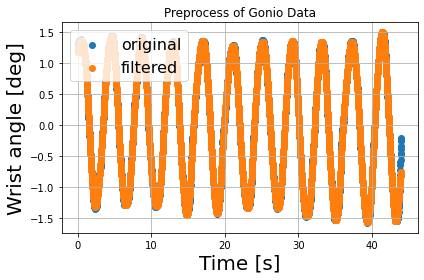

resampled_theta: 


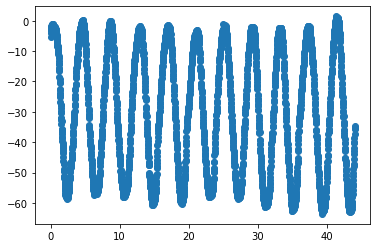

theta_zscore: 


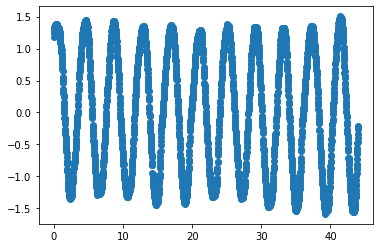

In [29]:
##### 図で確認

x = time
y1 = theta_before_low
y2 = theta_lowpass
print("x: ")
print(x.shape)
print("y1: ")
print(y1.shape)
print("y2: ")
print(y2.shape)

print("theta_before_low and theta_lowpass: ")
fig = plt.figure()
plt.title("Preprocess of Gonio Data")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

print("resampled_theta: ")
plt.scatter(time, resampled_theta, label='original')
plt.show()

print("theta_zscore: ")
plt.scatter(time, theta_zscore, label='normalized')
plt.show()

In [30]:
##### 処理データ・図の保存

theta = theta_lowpass

print("time: ")
print(time, time.shape)
print("theta: ")
print(theta, theta.shape)

# 前処理したゴニオデータを保存
with open(filtered_theta_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Time", "Gonio"])
    for i in range(theta.shape[0]):
        writer.writerow([time[i], theta[i]])
    f.close()
    
# フィルターをかける前後のデータの比較グラフを保存
fig.savefig(gonio_raw_vs_filtered_file_path)


time: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
theta: 
[ 1.18810211  1.19788005  1.20766388 ... -0.77062369 -0.76291351
 -0.75639884] (2728,)


In [31]:


##############################     エコーデータの処理     ##############################



In [32]:
##### エコーデータ関連パス設定

print("Target Echo Data: " + echo_file)

# データ読み込み用パス
echo_path = data_per_info_path + "/EchoData"
target_echo_path = echo_path + "/" + echo_file

# データ前処理用パス
preprocessed_movie_path = echo_path + "/PreprocessedMovie/" + echo_file

# データ保存用パス
echo_processed_path = analysis_path + "/ProcessedData/EchoProcessed"
echo_raw_vs_filtered_file_path = echo_processed_path + "/EchoRawVSFiltered/" + echo_file.split(".")[0] + ".png"
filtered_fp_file_path = echo_processed_path + "/FilteredFP/" + echo_file.split(".")[0] + ".csv"
fp_for_analysis_file_path = echo_processed_path + "/FPForAnalysis/" + echo_file.split(".")[0] + ".csv"
fp_for_visualize_file_path = echo_processed_path + "/FPForVisualize/" + echo_file.split(".")[0] + ".csv"
opticalflow_movie_file_path = echo_processed_path + "/OpticalflowMovie/" + echo_file



print("target_echo_path: " + str(target_echo_path))


Target Echo Data: 20221108 133918.mp4
target_echo_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_pattern1/EchoData/20221108 133918.mp4


In [33]:
##### 動画の前処理（実験データごとに最初の1回だけ実行する）
# 1. 動画時間を計測時間に合わせる（必要なフレーム数だけを保存）
# 2. 画像内の不要な部分を削る(スクリーン中のエコー部分のみ)


# preprocessed_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(preprocessed_movie_path):
    
    # 動画取得
    video = cv2.VideoCapture(target_echo_path)

    # 動画情報
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # フレームレート確認
    print("--Before Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    # 必要なフレームのみ取り出す
    start_frame = start_time * frame_rate # 876
    end_frame = end_time * frame_rate # 4088

    # 保存の準備
    fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    new_size = (right - left, bottom - top)
    save = cv2.VideoWriter(preprocessed_movie_path, fmt, frame_rate, new_size)

    for i in range(end_frame):    # 1.の処理
        ret, frame = video.read()
        if ret == False:
            break
        if i < start_frame:
            continue

        frame = frame[top:bottom, left:right]   # 2.の処理
        frame = cv2.resize(frame, new_size)
        cv2.imshow("check frame", frame)
        key = cv2.waitKey(10)
        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        save.write(frame)

    save.release()
    video.release()
    cv2.destroyAllWindows()

    processed_video = cv2.VideoCapture(preprocessed_movie_path)
    # 動画情報
    width = int(processed_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(processed_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(processed_video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(processed_video.get(cv2.CAP_PROP_FRAME_COUNT))
    processed_video.release()
    print("--After Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    print("Preprocessing is done")
else:
    print("Processed Movie already Exists")

--Before Processing--
WIDTH: 1172, HEIGHT: 608
FRAME RATE: 62,
FRAME COUNT: 3969

--After Processing--
WIDTH: 1000, HEIGHT: 560
FRAME RATE: 62,
FRAME COUNT: 2728

Preprocessing is done


In [34]:
##### オプティカルフロー

# 動画取得
video = cv2.VideoCapture(preprocessed_movie_path)

# Shi-Tomasi法のパラメータ（コーナー：物体の角を特徴点として検出）
ft_params = dict(maxCorners=maxCorners,       # 特徴点の最大数
qualityLevel=qualityLevel,    # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
minDistance=minDistance,       # 特徴点間の最小距離
blockSize=blockSize)         # 特徴点の計算に使うブロック（周辺領域）サイズ

# Lucal-Kanade法のパラメータ（追跡用）
lk_params = dict(winSize=(80,80),     # オプティカルフローの推定の計算に使う周辺領域サイズ
maxLevel=4,          # ピラミッド数
criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))       # 探索アルゴリズムの終了条件

# # 動画情報
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = int(video.get(cv2.CAP_PROP_FPS)) # 73, 62, 54, 48, or 43
size = (width, height)  # (right - left, 560)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) # 3212
print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

# 最初のフレームを取得してグレースケール変換
ret, frame = video.read()
frame_pre = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# 最初のフレームのみさらにトリミング
frame_pre_first = frame_pre[trim_h : height - trim_h, trim_w : width - trim_w]

# Shi-Tomasi法で特徴点の検出
feature_pre = cv2.goodFeaturesToTrack(frame_pre_first, mask=None, **ft_params)

# 座標をトリミング前のものに修正
for v in feature_pre:
    v[0][0] += trim_w
    v[0][1] += trim_h

# mask用の配列を生成
mask = np.zeros_like(frame)

frame_num = 0
# 動画終了まで繰り返し
while(video.isOpened() and frame_num < frame_count):

    # 次のフレームを取得し、グレースケールに変換
    ret, frame = video.read()
    if ret == False:
        break

    frame_now = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Lucas-Kanade法でフレーム間の特徴点のオプティカルフローを計算
    feature_now, status, err = cv2.calcOpticalFlowPyrLK(frame_pre, frame_now, feature_pre, None, **lk_params)

    # オプティカルフローを検出した特徴点を取得
    good1 = feature_pre[status == 1] # 1フレーム目
    good2 = feature_now[status == 1] # 2フレーム目

    # 座標を保存する配列を初期化、初期位置を保存
    if frame_num == 0:
        feature_points_of_all = np.empty([0, good1.shape[0], 2])
        feature_points_of_t = good1.reshape([1, good1.shape[0], 2])
        feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

        first_num = good1.shape[0]
        print("Num of feature point at first: " + str(first_num))

    # statusが0となるインデックスを取得
    vanish = np.where(status == 0)[0]

    # position_allからstatus=0の要素を削除
    for i, v in enumerate(vanish):
        # 最初のフレーム間で特徴点が消えている場合は何もしない
        if frame_num == 0:
            break
        feature_points_of_all = np.delete(feature_points_of_all, v - i, 1)

    # 各時刻における座標を保存
    feature_points_of_t = good2.reshape([1, good2.shape[0], 2])
    feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

    # 特徴点とオプティカルフローをフレーム・マスクに描画
    for i, (pt1, pt2) in enumerate(zip(good1, good2)):
        x1, y1 = pt1.ravel() # 1フレーム目の特徴点座標
        x2, y2 = pt2.ravel() # 2フレーム目の特徴点座標

        # 軌跡を描画（過去の軌跡も残すためにmaskに描く）
        mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)

        # 現フレームにオプティカルフローを描画
        frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

    # フレームとマスクの論理積（合成）
    img = cv2.add(frame, mask)

    # ウィンドウに表示
    cv2.imshow('mask', img)

    # 次のフレーム、ポイントの準備
    frame_pre = frame_now.copy() # 次のフレームを最初のフレームに設定
    feature_pre = good2.reshape(-1, 1, 2) # 次の点を最初の点に設定

    # qキーが押されたら途中終了
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    frame_num += 1

last_num = good2.shape[0]
print("Num of feature point at last: " + str(last_num) + "\n\n")

# 終了処理
cv2.destroyAllWindows()
video.release()

print("feature_points_of_all: ")
print(feature_points_of_all, feature_points_of_all.shape)

FRAME COUNT: 2728,
WIDTH: 1000, HEIGHT: 560

Num of feature point at first: 291
Num of feature point at last: 287


feature_points_of_all: 
[[[141.         179.        ]
  [693.         167.        ]
  [710.         185.        ]
  ...
  [278.         186.        ]
  [753.         331.        ]
  [510.         153.        ]]

 [[141.64419556 178.4591217 ]
  [693.22180176 166.96304321]
  [710.26074219 184.93536377]
  ...
  [279.48522949 185.39094543]
  [753.0748291  331.00128174]
  [511.2277832  152.66238403]]

 [[142.32736206 178.05010986]
  [693.62402344 166.92472839]
  [710.61700439 184.84112549]
  ...
  [280.46520996 185.01086426]
  [753.23205566 331.07330322]
  [512.27923584 152.39581299]]

 ...

 [[114.64749908 184.79190063]
  [627.9755249  142.56625366]
  [701.49560547 176.90299988]
  ...
  [201.44177246 181.89283752]
  [757.47717285 317.0072937 ]
  [412.26348877 146.46359253]]

 [[114.50415802 184.93722534]
  [627.31121826 142.60726929]
  [701.222229   176.93606567]
  ...
  [200

In [35]:
##### 特徴点の選出

print("特徴点選出パターン: " + str(fp_selection_pattern))

print("feature_points_of_all: " + str(feature_points_of_all.shape))

# 各特徴点の相関係数をリスト化
coef_list = list()
for i in range(feature_points_of_all.shape[1]):
    feature_point = feature_points_of_all[:, i, :]
    feature_point_x = feature_point[:, 0]
    feature_point_y = feature_point[:, 1]
    coef_x = np.corrcoef(theta.reshape(-1), feature_point_x)[0][1]
    coef_y = np.corrcoef(theta.reshape(-1), feature_point_y)[0][1]
    coef_ave = np.average([coef_x, coef_y])
#     # 確認
#     if i < 3:
#         print("coef_x: " + str(coef_x))
#         print("coef_y: " + str(coef_y))
#         print("coef_ave: " + str(coef_ave))

    # 特徴点選出パターン
    if fp_selection_pattern == 1:
        # パターン１
        coef_list.append(max(coef_x, coef_y))
    elif fp_selection_pattern == 2:
        # パターン２
        coef_list.append(coef_ave)

print("coef_list: " + str(len(coef_list)))
# print(coef_list)

# coef_listから相関係数の大きい順に並び変え，feature_num個だけ取り出す
selection_list = sorted(coef_list, reverse=True)[:feature_num]
print("selection_list: " + str(len(selection_list)))
print(selection_list)

# データ保存用配列を準備
selected_feature_points = np.empty([feature_points_of_all.shape[0], 0, 2])
feature_points_for_analysis = np.empty([feature_points_of_all.shape[0], 0])

# selection_listで取り出したものに該当する特徴点を選出する
for i in range(feature_points_of_all.shape[1]):
    feature_point = feature_points_of_all[:, i, :]
    feature_point_x = feature_point[:, 0]
    feature_point_y = feature_point[:, 1]
    coef_x = np.corrcoef(theta.reshape(-1), feature_point_x)[0][1]
    coef_y = np.corrcoef(theta.reshape(-1), feature_point_y)[0][1]
    coef_ave = np.average([coef_x, coef_y])

    # 特徴点選出パターン
    if fp_selection_pattern == 1:
        # パターン１
        if coef_x in selection_list:
            feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
            selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
            feature_point_x_reshape = feature_point_x.reshape([feature_point_x.shape[0], 1])
            feature_points_for_analysis = np.append(feature_points_for_analysis, feature_point_x_reshape, axis=1)
            # 確認
            if i < 50:
                print("coef_x: " + str(coef_x))
        elif coef_y in selection_list:
            feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
            selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
            feature_point_y_reshape = feature_point_y.reshape([feature_point_y.shape[0], 1])
            feature_points_for_analysis = np.append(feature_points_for_analysis, feature_point_y_reshape, axis=1)
            # 確認
            if i < 50:
                print("coef_y: " + str(coef_y))
    elif fp_selection_pattern == 2:
        # パターン２
        if coef_ave in selection_list:
            feature_point_reshape = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
            selected_feature_points = np.append(selected_feature_points, feature_point_reshape, axis=1)
if fp_selection_pattern == 2:
    feature_points_for_analysis = selected_feature_points.reshape([selected_feature_points.shape[0], selected_feature_points.shape[1]*2])


print("selected_feature_points: " + str(selected_feature_points.shape))
print("feature_points_for_analysis: " + str(feature_points_for_analysis.shape))

特徴点選出パターン: 1
feature_points_of_all: (2728, 287, 2)
coef_list: 287
selection_list: 50
[0.6219865053211628, 0.6212524407426433, 0.611587550919004, 0.6084013707847205, 0.591140152798417, 0.5901179852009961, 0.5797719079916556, 0.579323779862589, 0.5712029448387995, 0.5637500719111778, 0.5529408789506834, 0.5522437336708592, 0.5446825152878014, 0.538685676102904, 0.5327556227751338, 0.5313693999101876, 0.5302340017252029, 0.5293129028675276, 0.5265667893773616, 0.5260525248164974, 0.5256623077382245, 0.5255295086624762, 0.5240021218786632, 0.5239663097498309, 0.5235827439129118, 0.5229870448049205, 0.5217837273116023, 0.521385101140358, 0.5204551138516083, 0.5187042703702069, 0.5182840655143444, 0.5164902915447529, 0.514481737807212, 0.5139678533143252, 0.512342104082798, 0.512207421416415, 0.5119504047133432, 0.5086308145519403, 0.5072317364418617, 0.5061893233120796, 0.4987792084275172, 0.4976917256560945, 0.49613732009004935, 0.4955335028655006, 0.49504490354330927, 0.49256505591051564,

In [36]:
##### 特徴点の選出・csvファイルへの保存

# データの形を修正
feature_points_data = selected_feature_points.reshape(
    [selected_feature_points.shape[0], selected_feature_points.shape[1] * 2]) # (3212, 100)
print("feature_points_data: ")
print(feature_points_data, feature_points_data.shape)

# 特徴点データを保存
with open(fp_for_visualize_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Feature Points Data"])
    for each_time_data in feature_points_data:
        writer.writerow(each_time_data)
    f.close()
print("Save completed")

# 特徴点（片方座標）データを保存
print("feature_points_for_analysis: ")
print(feature_points_for_analysis, feature_points_for_analysis.shape)
with open(fp_for_analysis_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Feature Points Data"])
    for each_time_data in feature_points_for_analysis:
        writer.writerow(each_time_data)
    f.close()
print("Save completed")


feature_points_data: 
[[141.         179.         342.         ... 186.         510.
  153.        ]
 [141.64419556 178.4591217  343.62136841 ... 185.39094543 511.2277832
  152.66238403]
 [142.32736206 178.05010986 345.05761719 ... 185.01086426 512.27923584
  152.39581299]
 ...
 [114.64749908 184.79190063 229.00296021 ... 181.89283752 412.26348877
  146.46359253]
 [114.50415802 184.93722534 228.26348877 ... 181.91860962 411.28295898
  146.44430542]
 [114.26373291 185.00082397 227.9019165  ... 182.00889587 410.68319702
  146.52253723]] (2728, 100)
Save completed
feature_points_for_analysis: 
[[141.         342.         449.         ... 409.         278.
  510.        ]
 [141.64419556 343.62136841 450.4901123  ... 411.55978394 279.48522949
  511.2277832 ]
 [142.32736206 345.05761719 452.08172607 ... 414.34320068 280.46520996
  512.27923584]
 ...
 [114.64749908 229.00296021 276.51989746 ... 232.32182312 201.44177246
  412.26348877]
 [114.50415802 228.26348877 275.77661133 ... 231.41633606

EchoData: 20221108 133918.mp4
GonioData: 202211081339.csv
feature_points_for_visualize: 
[[141.         179.         342.         ... 186.         510.
  153.        ]
 [141.64419556 178.4591217  343.62136841 ... 185.39094543 511.2277832
  152.66238403]
 [142.32736206 178.05010986 345.05761719 ... 185.01086426 512.27923584
  152.39581299]
 ...
 [114.64749908 184.79190063 229.00296021 ... 181.89283752 412.26348877
  146.46359253]
 [114.50415802 184.93722534 228.26348877 ... 181.91860962 411.28295898
  146.44430542]
 [114.26373291 185.00082397 227.9019165  ... 182.00889587 410.68319702
  146.52253723]] (2728, 100)
theta: 
[ 1.18810211  1.19788005  1.20766388 ... -0.77062369 -0.76291351
 -0.75639884] (2728,)


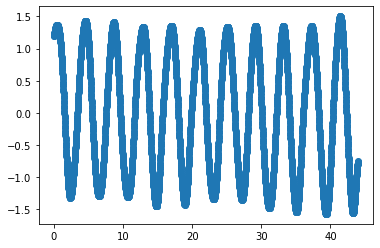

In [37]:
##### 特徴点データとゴニオデータの読み込み

print("EchoData: " + echo_file)
print("GonioData: " + gonio_file)

with open(fp_for_visualize_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    feature_points_for_visualize = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        feature_points_for_visualize.append(row)
    f.close()

feature_points_for_visualize = np.array(feature_points_for_visualize).astype(float)[:, :]

print("feature_points_for_visualize: ")
print(feature_points_for_visualize, feature_points_for_visualize.shape)
print("theta: ")
print(theta, theta.shape)


plt.scatter(time, theta)
plt.show()

In [38]:
##### 選出した特徴点の描画・動画保存

# 特徴点データを元の形に直す（1つの特徴点につきx,y座標の2データを持つ）
feature_points_for_visualize = feature_points_for_visualize.reshape([feature_points_for_visualize.shape[0], feature_num, 2]) # (3212, 50, 2)
print("feature_points_for_visualize: ")
print(feature_points_for_visualize, feature_points_for_visualize.shape)

# 動画取得
video = cv2.VideoCapture(preprocessed_movie_path)

# 動画情報
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
size = (width, height)  # (right - left, 560)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = int(video.get(cv2.CAP_PROP_FPS))
print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

# 保存の準備
fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
save = cv2.VideoWriter(opticalflow_movie_file_path, fmt, frame_rate, size)

# 最初のフレームを取得
ret, frame = video.read()

# mask用の配列を生成
mask = np.zeros_like(frame)

# 最初の特徴点の座標を取得
points_pre = feature_points_for_visualize[0] # (50, 2)

# 動画終了まで繰り返し
for t in range(feature_points_for_visualize.shape[0] - 1):

    # 現在のフレームを取得
    ret, frame = video.read()
    if ret == False:
        print("false t: " + str(t))
        break

    # 現在の特徴点の座標を取得
    points_now = feature_points_for_visualize[t+1]

    # 現在の関節角度を取得
    theta_now = round(theta[t], 2)

    # オプティカルフローと現在の特徴点をmask, frameに描画
    for p_pre, p_now in zip(points_pre, points_now):
        x1, y1 = p_pre[0], p_pre[1]
        x2, y2 = p_now[0], p_now[1]

        mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)
        frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

        # 関節角度情報を描画
        angle = "Wrist Angle: " + str(theta_now)
        # org = (20, 460) # 挿入する座標
        cv2.putText(frame, angle, wrist_angle_position, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5, color=(255, 255, 255))

    # frameとmaskの合成
    img = cv2.add(frame, mask)

    # ウィンドウに表示
    cv2.imshow("mask", img)

    # フレームごとに保存
    save.write(img)

    # 特徴点の更新
    points_pre = points_now

    # qキーが押されたら途中終了
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# 終了処理
cv2.destroyAllWindows()
video.release()
save.release()

print("Save completed")

# 特徴点データを解析用の形に戻す
feature_points_for_visualize = feature_points_for_visualize.reshape([feature_points_for_visualize.shape[0], feature_num * 2]) # (3212, 100)

feature_points_for_visualize: 
[[[141.         179.        ]
  [342.         168.        ]
  [449.         165.        ]
  ...
  [409.         161.        ]
  [278.         186.        ]
  [510.         153.        ]]

 [[141.64419556 178.4591217 ]
  [343.62136841 167.42658997]
  [450.4901123  164.64395142]
  ...
  [411.55978394 160.66506958]
  [279.48522949 185.39094543]
  [511.2277832  152.66238403]]

 [[142.32736206 178.05010986]
  [345.05761719 167.10775757]
  [452.08172607 164.45921326]
  ...
  [414.34320068 160.46932983]
  [280.46520996 185.01086426]
  [512.27923584 152.39581299]]

 ...

 [[114.64749908 184.79190063]
  [229.00296021 166.62283325]
  [276.51989746 154.94949341]
  ...
  [232.32182312 154.44656372]
  [201.44177246 181.89283752]
  [412.26348877 146.46359253]]

 [[114.50415802 184.93722534]
  [228.26348877 166.56758118]
  [275.77661133 154.91418457]
  ...
  [231.41633606 154.39193726]
  [200.88348389 181.91860962]
  [411.28295898 146.44430542]]

 [[114.26373291 185.000

EchoData: 20221108 133918.mp4

--Before Processing--


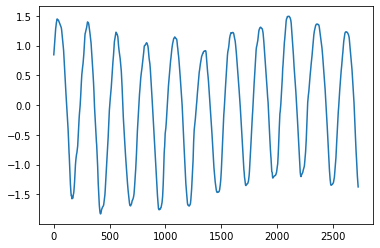

(2728, 50)
(2728,)

--After Processing--
processed_feature_points: 
[[ 1.16236643  1.25740385  1.22194745 ...  1.65801943  1.47526038
   0.84641805]
 [ 1.22049798  1.29785999  1.25108751 ...  1.70922096  1.53250615
   0.87386378]
 [ 1.28214622  1.33369705  1.28221249 ...  1.76489565  1.57027792
   0.89736783]
 ...
 [-1.21565623 -1.56208098 -2.15100689 ... -1.87594761 -1.47555318
  -1.3383726 ]
 [-1.22859118 -1.58053216 -2.1655423  ... -1.89405941 -1.49707152
  -1.36029125]
 [-1.25028689 -1.58955406 -2.17452519 ... -1.90350202 -1.51469117
  -1.37369826]] (2728, 50)
x: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
y1: 
[ 1.16236643  1.22049798  1.28214622 ... -1.21565623 -1.22859118
 -1.25028689] (2728,)
y2: 
[ 1.16236643  1.22049798  1.28214622 ... -1.21565623 -1.22859118
 -1.25028689] (2728,)


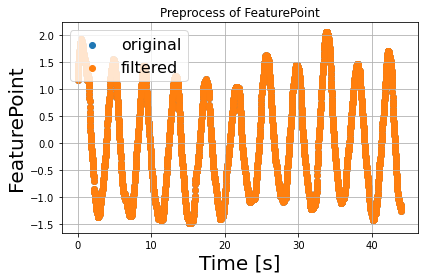

Save completed


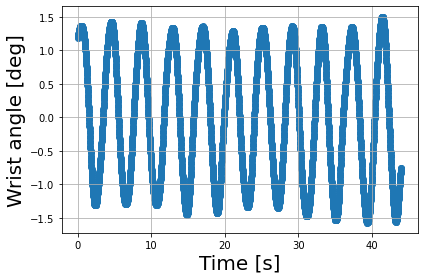

In [39]:
##### 特徴点データの処理・保存
print("EchoData: " + echo_file)

print("\n--Before Processing--")
# print("feature_points: ")
# print(feature_points, feature_points.shape)

with open(fp_for_analysis_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    feature_points = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        feature_points.append(row)
    f.close()
feature_points = np.array(feature_points).astype(float)[:, :]

# 正規化
select_normalize_position = 2
#1:正規化しない、2:正規化する

if select_normalize_position==1:
    processed_feature_points = feature_points

if select_normalize_position==2:
   
    data_fp = feature_points
    processed_feature_points = feature_points

    #NumPyで配列の正規化(normalize)、標準化する方法
    #https://deepage.net/features/numpy-normalize.html
    import numpy as np
    def zscore(x, axis = None):
        xmean = x.mean(axis=axis, keepdims=True)
        xstd  = np.std(x, axis=axis, keepdims=True)
        zscore = (x-xmean)/xstd
        return zscore, xmean, xstd

    #すべての特徴点の正規化
    for i in range(data_fp.shape[1]):
        fp_part,fp_mean,fp_std = zscore(data_fp[:,i])
        processed_feature_points[:,i] = fp_part

    plt.plot(fp_part)
    plt.show()

    print('===============')
    print(feature_points.shape)
    print(fp_part.shape)
    print('===============')
    

# # ローパスフィルタ
# #フィルター選択(角度情報)
# #1: raw, 2:lowpath
# lowpass_filter_pattern = 1

#ローパス
samplerate = 30
fp_l = 0.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs_l = 2.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass_l = 3 # 通過域端最大損失[dB]
gstop_l = 40 # 阻止域端最小損失[dB]
from scipy import signal
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y  

if lowpass_filter_pattern == 2:
    for i in range(data_fp.shape[1]):
        fp_part,fp_mean,fp_std = zscore(processed_feature_points[:,i])
        fp_part_low = lowpass(fp_part, samplerate, fp_l, fs_l, gpass_l, gstop_l)
        plt.scatter(time,fp_part_low,s=5)

        processed_feature_points[:,i] = fp_part_low


# 特徴点データを保存
with open(filtered_fp_file_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Processed Feature Points Data"])
    for each_time_data in processed_feature_points:
        writer.writerow(each_time_data)
    f.close()
    

print("\n--After Processing--")
print("processed_feature_points: ")
print(processed_feature_points, processed_feature_points.shape)


# 比較グラフの表示・保存（Noつ目の特徴点のみ）

No = 0
x = time
y1 = feature_points[:, No]
y2 = processed_feature_points[:, No]

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig = plt.figure()
plt.title("Preprocess of FeaturePoint")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("FeaturePoint", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig(echo_raw_vs_filtered_file_path)

print("Save completed")

plt.scatter(time, theta)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:


##############################     解析     ##############################



In [41]:
##### 結果保存用パス設定

fp_behavior_file_path = analysis_path + "/Results/FPBehavior/" + gonio_file.split(".")[0]
angle_estimation = analysis_path + "/Results/AngleEstimation/" + gonio_file.split(".")[0]



In [42]:
##### データ読み込み

print("EchoData : " + echo_file)
print("GonioData: " + gonio_file)

with open(filtered_fp_file_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    X = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        X.append(row)
    f.close()

X = np.array(X).astype(float)[:, :]
theta = np.array(theta).astype(float)[:, np.newaxis]

print("X: ")
print(X, X.shape)
print("theta: ")
print(theta, theta.shape)

EchoData : 20221108 133918.mp4
GonioData: 202211081339.csv
X: 
[[ 1.16236643  1.25740385  1.22194745 ...  1.65801943  1.47526038
   0.84641805]
 [ 1.22049798  1.29785999  1.25108751 ...  1.70922096  1.53250615
   0.87386378]
 [ 1.28214622  1.33369705  1.28221249 ...  1.76489565  1.57027792
   0.89736783]
 ...
 [-1.21565623 -1.56208098 -2.15100689 ... -1.87594761 -1.47555318
  -1.3383726 ]
 [-1.22859118 -1.58053216 -2.1655423  ... -1.89405941 -1.49707152
  -1.36029125]
 [-1.25028689 -1.58955406 -2.17452519 ... -1.90350202 -1.51469117
  -1.37369826]] (2728, 50)
theta: 
[[ 1.18810211]
 [ 1.19788005]
 [ 1.20766388]
 ...
 [-0.77062369]
 [-0.76291351]
 [-0.75639884]] (2728, 1)


In [43]:
##### 学習データ・テストデータの分割

# 訓練データとテストデータの区切り位置
devide_num = X.shape[0] * 4 // 5

print(devide_num)

X_train = X[:devide_num]
theta_train = theta[:devide_num]

print("devide_num: " + str(devide_num))
print("X_train: ")
print(X_train, X_train.shape)
print("theta_train: ")
print(theta_train, theta_train.shape)

2182
devide_num: 2182
X_train: 
[[ 1.16236643  1.25740385  1.22194745 ...  1.65801943  1.47526038
   0.84641805]
 [ 1.22049798  1.29785999  1.25108751 ...  1.70922096  1.53250615
   0.87386378]
 [ 1.28214622  1.33369705  1.28221249 ...  1.76489565  1.57027792
   0.89736783]
 ...
 [-0.45782151 -0.92105275 -1.08604053 ... -1.00159332 -0.78712941
  -0.11344073]
 [-0.47551929 -0.94340265 -1.11160284 ... -1.02439316 -0.80849013
  -0.14581184]
 [-0.51116613 -0.9569473  -1.14339265 ... -1.04632133 -0.83607909
  -0.17337013]] (2182, 50)
theta_train: 
[[ 1.18810211]
 [ 1.19788005]
 [ 1.20766388]
 ...
 [-1.52865769]
 [-1.52314471]
 [-1.51658301]] (2182, 1)


In [44]:
##### 重みの導出

# #最小事情法で正則化するか
# #1:正則化なし、2:正則化あり
# regularization_pattern = 2

X_T = X_train.T
X_T_X = np.dot(X_T, X_train)
I = np.eye(X_T_X.shape[0])

if regularization_pattern==1:
    inv = np.linalg.pinv(X_T_X)

if regularization_pattern==2:
    inv = np.linalg.pinv(X_T_X + lam * I)

W = np.dot(np.dot(inv, X_T), theta_train)

W_reshape = W.reshape(-1)
W_max_index = np.argmax(W_reshape)
W_max = np.max(W_reshape)
W_min_index = np.argmin(W_reshape)
W_min = np.min(W_reshape)

print("X_T: " + str(X_T.shape))
print("X_T_X: " + str(X_T_X.shape))
print("inv: " + str(inv.shape))
print("W: " + str(W.shape))
# print(W)
print("W_max: ")
print("index: " + str(W_max_index) + " value: " + str(W_max))
print("W_min: ")
print("index: " + str(W_min_index) + " value: " + str(W_min))

X_T: (50, 2182)
X_T_X: (50, 50)
inv: (50, 50)
W: (50, 1)
W_max: 
index: 10 value: 3.0470096583062354
W_min: 
index: 48 value: -2.837534155160665


angle: 
(2728,)
X_max: 
(2728,)
X_min: 
(2728,)


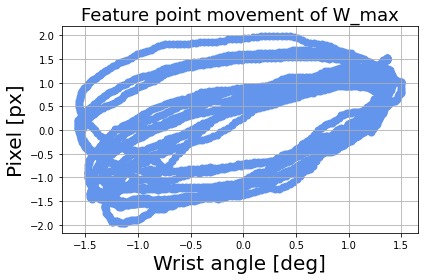

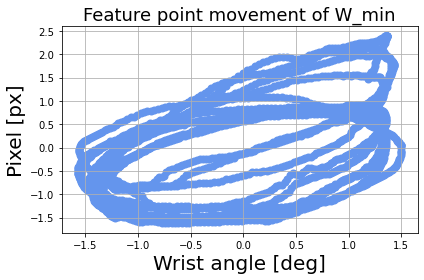

Save completed


In [45]:
##### 関節角度-特徴点座標のグラフを作成・保存

angle = theta.reshape(-1)
# 重みが最大・最小となっている特徴点のみ取り出す
X_max = X[:, W_max_index]
X_min = X[:, W_min_index]

print("angle: ")
print(angle.shape)
print("X_max: ")
print(X_max.shape)
print("X_min: ")
print(X_min.shape)

def Visualize(x, y, save_path, max_or_min):
    fig = plt.figure()
    plt.title("Feature point movement of W_" + max_or_min, fontsize=18)
    plt.xlabel("Wrist angle [deg]", fontsize=20)
    plt.ylabel("Pixel [px]", fontsize=20)
    plt.scatter(x, y, color="cornflowerblue", linewidth=2, label="Feature Point Movement")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    fig.savefig(save_path + max_or_min + ".png")
    plt.close()

Visualize(angle, X_max, fp_behavior_file_path, "max")
Visualize(angle, X_min, fp_behavior_file_path, "min")

print("Save completed")

In [46]:
##### 関節角度の推定値を導出

theta_pred = np.dot(X, W)

print("theta_pred: ")
print(theta_pred, theta_pred.shape)

theta_pred: 
[[1.61079152]
 [1.62143867]
 [1.67370116]
 ...
 [0.46846898]
 [0.43909142]
 [0.43273712]] (2728, 1)


x: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
y1: 
[ 1.18810211  1.19788005  1.20766388 ... -0.77062369 -0.76291351
 -0.75639884] (2728,)
y2: 
[1.61079152 1.62143867 1.67370116 ... 0.46846898 0.43909142 0.43273712] (2728,)


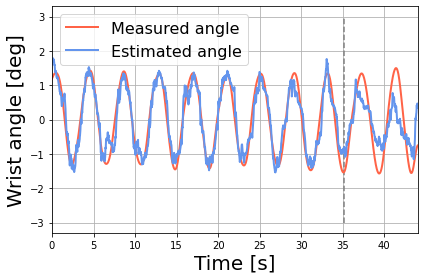

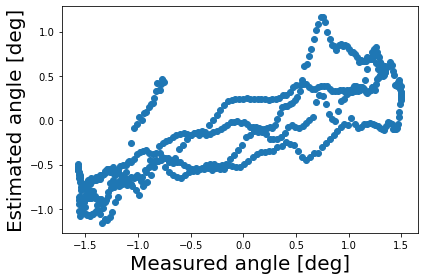

In [47]:
##### グラフ作成・保存

x = time
y1 = theta.reshape(-1)
y2 = theta_pred.reshape(-1)

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig1 = plt.figure()
# plt.title("A result of estimating wrist joint angle", fontsize=18)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.plot(x, y1, color="tomato", linewidth=2, label="Measured angle")
plt.plot(x, y2, color="cornflowerblue", linewidth=2, label="Estimated angle")
line_position = devide_num / echo_frame_rate

#plt.vlines(line_position, min_height, max_height, "gray", linestyles="dashed")
plt.vlines(line_position, -3, 3, "gray", linestyles="dashed")

#plt.ylim(min_height, max_height) #extensor

plt.xlim(0, x.shape[0] / echo_frame_rate)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
fig1.savefig(angle_estimation + "_estimation.png")

fig2 = plt.figure()
# plt.title("Scatter plots of estimated and measured angle", fontsize=16)
plt.xlabel("Measured angle [deg]", fontsize=20)
plt.ylabel("Estimated angle [deg]", fontsize=20)
plt.scatter(y1[devide_num:], y2[devide_num:])
plt.tight_layout()
fig2.savefig(angle_estimation + "_scatter.png")

plt.show()
plt.close()

In [48]:
##### RMSE，決定係数R2，相関係数coeffを導出

theta_test = theta.reshape(-1)[devide_num:]
theta_pred_test = theta_pred.reshape(-1)[devide_num:]

T = theta_test.shape[0]
L = np.sum((theta_test - theta_pred_test)**2)
RMSE = np.sqrt(L/T)


if select_normarize_joint == 2:
    RMSE = float(theta_std*RMSE)

R2 = r2_score(theta_test, theta_pred_test)

coef = np.corrcoef(theta_test, theta_pred_test)[0][1]

print("theta_test: ")
print(theta_test.shape)
print("theta_pred_test: ")
print(theta_pred_test.shape)
print("T: " + str(T))
print("L: " + str(L))
print("RMSE: " + str(RMSE))
    
print("決定係数 R2: " + str(R2))
print("相関係数: " + str(coef) + "\n")

theta_test: 
(546,)
theta_pred_test: 
(546,)
T: 546
L: 241.12919452206748
RMSE: 13.983529465321006
決定係数 R2: 0.5972837756215391
相関係数: 0.8409362472631852



In [49]:
##### 結果の保存


### datasheet_all.csvへの書き込み
# 結果の更新
target_df.loc[data_No, ["RMSE"]] = RMSE
target_df.loc[data_No, ["R2"]] = R2
target_df.loc[data_No, ["Corrcoef"]] = coef
target_df.loc[data_No, ["Updated Date"]] = updated_date

print("-------------  target_df  ---------------------")
print(target_df)
print("-----------------------------------------------")

# datasheet_all.csv用のデータフレームを更新
datasheet_all_df.update(target_df)

# datasheet_all.csvに書き込み
datasheet_all_df.to_csv(datasheet_all_path, encoding="shift_jis")


### datasheet_per_info.csvへの書き込み

## target_per_info_dfが空の場合
if target_per_info_df.empty:
    new_data_per_info = [(per_info_No, data_No, gonio_file, echo_file, date, subject, pattern, trial_num, depth, analysis_num, 
                 fp_selection_pattern, fp_detection_pattern, frame_range_pattern, lowpass_filter_pattern, regularization_pattern, 
                 RMSE, R2, coef, updated_date)]
    new_df_per_info = pd.DataFrame(data=new_data_per_info, columns=cols_per_info)
    new_df_per_info.set_index("Per Info No", inplace=True)
    print("-------------  new_df_per_info  ---------------------")
    print(new_df_per_info)
    print("-----------------------------------------------------")

    # datasheet_per_info.csvに書き込み
    datasheet_per_info_df = datasheet_per_info_df.append(new_df_per_info)
    datasheet_per_info_df.to_csv(datasheet_per_info_path, encoding="shift_jis")
    
## target_per_info_dfが空でない場合
else:
    # 結果の更新
    target_per_info_df.loc[per_info_No, ["RMSE"]] = RMSE
    target_per_info_df.loc[per_info_No, ["R2"]] = R2
    target_per_info_df.loc[per_info_No, ["Corrcoef"]] = coef
    target_per_info_df.loc[per_info_No, ["Updated Date"]] = updated_date

    print("-------------  target_per_info_df  ---------------------")
    print(target_per_info_df)
    print("--------------------------------------------------------")

    # datasheet_per_info.csv用のデータフレームを更新
    datasheet_per_info_df.update(target_per_info_df)

    # datasheet_per_info.csvに書き込み
    datasheet_per_info_df.to_csv(datasheet_per_info_path, encoding="shift_jis")


print("Save completed")

-------------  target_df  ---------------------
                    Gonio                 Echo        Date Subject  Pattern  \
Data No                                                                       
7        202211081339.csv  20221108 133918.mp4  20221108.0  Katagi      1.0   

         Trial Num  Depth       RMSE        R2  Corrcoef      Updated Date  
Data No                                                                     
7              2.0   30.0  13.983529  0.597284  0.840936  2022/12/05 19:51  
-----------------------------------------------
-------------  new_df_per_info  ---------------------
             Data No             Gonio                 Echo      Date Subject  \
Per Info No                                                                     
2                  7  202211081339.csv  20221108 133918.mp4  20221108  Katagi   

             Pattern  Trial Num  Depth  Analysis Num  FP Selection Pattern  \
Per Info No                                                